In [1]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2025-05-28 23:23:45--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M   619KB/s    in 5.7s    

2025-05-28 23:23:52 (588 KB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [7]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [11]:
np.random.seed(0)
tf.random.set_seed(0)

In [13]:
df = pd.read_csv('AirlineTweets.csv')

In [15]:
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [29]:
df = df[df['airline_sentiment'].isin(['negative', 'positive'])]

df['target'] = df.airline_sentiment.map({
    'negative': 0,
    'positive': 1
})

df = df[['text', 'target']]

In [175]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.target, stratify = df.target)

In [177]:
vectorizer = TfidfVectorizer(stop_words = "english")
x_train_v = vectorizer.fit_transform(x_train)
x_test_v = vectorizer.transform(x_test)

x_train_v = x_train_v.toarray()
x_test_v = x_test_v.toarray()

### Model Building

In [180]:
D = x_train_v.shape[1]

input_layer = Input(shape = (D, ))
output_layer = Dense(1)(input_layer)
model = Model(inputs = input_layer, outputs = output_layer)

In [182]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10534)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        10,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,535 (41.15 KB)

 Trainable params: 10,535 (41.15 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
model.compile(
    loss = BinaryCrossentropy(from_logits = True),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [186]:
history = model.fit(x_train_v, y_train, 
                    epochs = 100, 
                    batch_size = 64, 
                    shuffle = True, 
                    verbose = 1,
                    validation_data = (x_test_v, y_test)
                   )

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.6727 - val_accuracy: 0.7952 - val_loss: 0.6102
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.7883 - loss: 0.5979 - val_accuracy: 0.7952 - val_loss: 0.5504
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.7883 - loss: 0.5438 - val_accuracy: 0.7952 - val_loss: 0.5075
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7883 - loss: 0.5042 - val_accuracy: 0.7952 - val_loss: 0.4760
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7883 - loss: 0.4746 - val_accuracy: 0.7952 - val_loss: 0.4523
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7883 - loss: 0.4518 - val_accuracy: 0.7952 - val_loss: 0.4338
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.7883 - loss: 0.4334 - val_accuracy: 0.7952 - val_loss: 0.4187
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7883 - loss: 0.4181 

### Viusalize the Loss and Accuracy

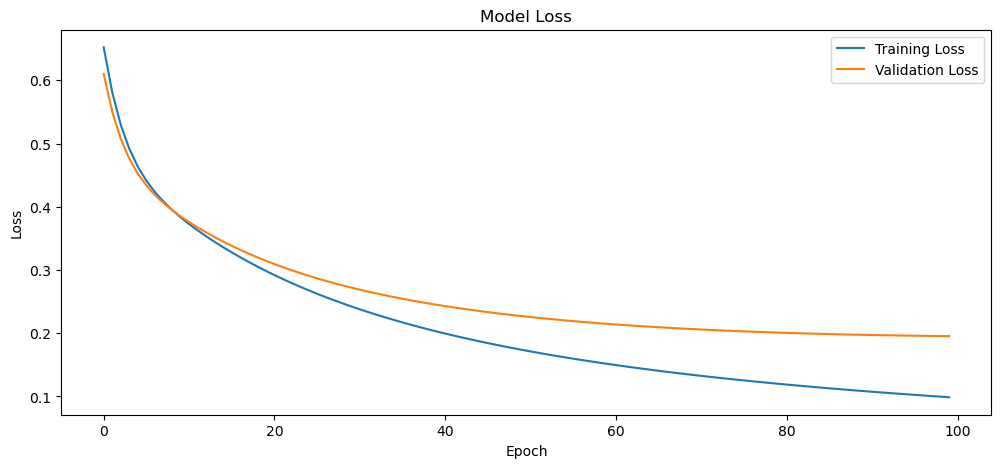

In [187]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

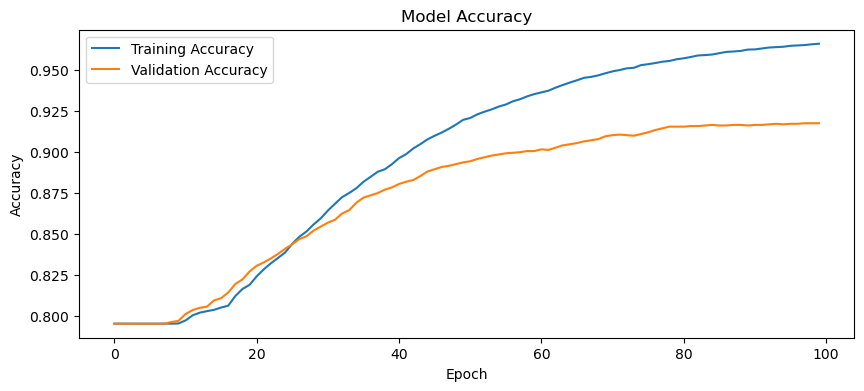

In [188]:
plt.figure(figsize = (10, 4))
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Predict the Train and Test data

In [192]:
y_train_pred_logits = model.predict(x_train_v)
y_test_pred_logits = model.predict(x_test_v)

y_train_prob = tf.nn.sigmoid(y_train_pred_logits).numpy()
y_test_prob = tf.nn.sigmoid(y_test_pred_logits).numpy()

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


In [194]:
y_train_pred_binary = (y_train_prob > 0.5).astype(int)
y_test_pred_binary = (y_test_prob > 0.5).astype(int)

### Measure metrics

#### Confusion Matrix

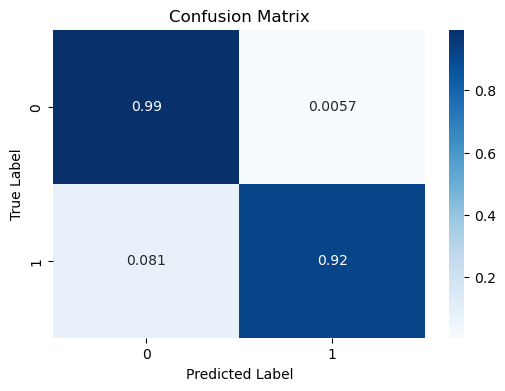

In [196]:
plt.figure(figsize = (6, 4))
cm_train = confusion_matrix(y_train, y_train_pred_binary, normalize = 'true')

sn.heatmap(cm_train, annot = True, cmap = 'Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

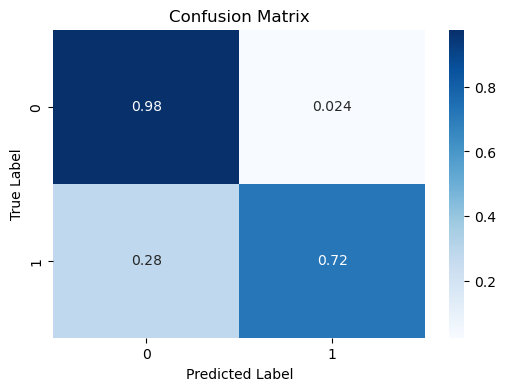

In [198]:
plt.figure(figsize = (6, 4))
cm_train = confusion_matrix(y_test, y_test_pred_binary, normalize = 'true')

sn.heatmap(cm_train, annot = True, cmap = 'Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [200]:
print("F1 score train: ", f1_score(y_train, y_train_pred_binary))
print("F1 score test: ", f1_score(y_test, y_test_pred_binary))

F1 score train:  0.9470930232558139
F1 score test:  0.794392523364486


In [202]:
print("AUC score train: ", roc_auc_score(y_train, y_train_pred_binary))
print("AUC score test: ", roc_auc_score(y_test, y_test_pred_binary))

AUC score train:  0.9568170458902081
AUC score test:  0.8477953617995421


In [206]:
model.layers

[<InputLayer name=input_layer_6, built=True>, <Dense name=dense_6, built=True>]

In [216]:
model.layers[1].get_weights()[0].shape

(10534, 1)

In [220]:
w = model.layers[1].get_weights()[0]

In [222]:
word_index_map = vectorizer.vocabulary_

In [224]:
word_index_map

{'usairways': 9939,
 'hold': 4901,
 '30': 477,
 'minutes': 6272,
 'amp': 1478,
 'counting': 2952,
 'cancelled': 2331,
 'flight': 4180,
 'reservation': 7929,
 'booked': 2094,
 '24': 385,
 'hours': 4978,
 'conf': 2813,
 'code': 2674,
 'f6dk04': 3964,
 'xzmscw': 10439,
 'united': 9816,
 'terrible': 9214,
 'maybemange': 6122,
 'airline': 1364,
 'alittlebetter': 1412,
 'arrived': 1632,
 'lax': 5711,
 'gate': 4463,
 'howisthatpossible': 4985,
 'thing': 9290,
 'airlines': 1366,
 'flights': 4212,
 'oc': 6753,
 'fll': 4221,
 'today': 9401,
 '700': 929,
 'switch': 9067,
 'notice': 6680,
 'apology': 1565,
 'flying': 4252,
 'unitedairlines': 9819,
 'virginamerica': 10056,
 'called': 2314,
 'weeks': 10213,
 'ago': 1340,
 'adding': 1273,
 '2014': 316,
 'elevate': 3686,
 'haven': 4784,
 'shown': 8470,
 'help': 4829,
 'jetblue': 5432,
 'mosaic': 6373,
 'customer': 3075,
 'fly': 4242,
 'jet': 5430,
 'blue': 2064,
 'alot': 1430,
 'min': 6260,
 'response': 7949,
 'time': 9354,
 'impressed': 5116,
 'offic

In [240]:
# look at the weights for each word
# try it with different threshold values!

threshold = 2

print("Most positive words: ")
word_weight_tuples = []

for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > 2:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key = lambda x: -x[1])

for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most positive words: 
thank 7.6378293
thanks 7.287607
great 5.283156
awesome 4.876693
love 4.872914
amazing 3.9304867
best 3.8663785
rock 3.8560967
excellent 3.8046546
kudos 3.555484


In [250]:
threshold = 2

print("Most negative words: ")
word_weight_tuples = []

for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key = lambda x: x[1])

for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most negative words: 
worst -6.6221857
rude -5.834259
hold -5.5978475
hrs -5.492461
fail -5.4291883
disappointed -5.2215405
hours -4.9941916
terrible -4.9050527
money -4.8276267
paid -4.8272924
